### Text Representation 

The classifiers and learning algorithms can not directly process the text documents in their original form,as most of them expect numerical feature vectors with a fixed size rather than raw text docs with variable length. Therefore , during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a resume in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored. 

TermFrequency and InverseDocumentFrequency is used for each document.

In [2]:
import pandas as pd
df = pd.read_csv('clean_data1.csv')
df = df.drop(['Resume'],axis=1)
df.rename(columns={'newer_res':'Resume'},inplace=True)
df.head()

,Unnamed: 0,ID,Category,Resume
0,0,1,HR,john h. smith p.h.r 800-991-5187 po box 1673 c...
1,1,2,HR,name surname address mobile no/email personal ...
2,2,3,HR,anthony brown hr assistant areas of expertise ...
3,3,4,HR,www.downloadmela.com satheesh email id career ...
4,4,5,HR,human resources director expert in organizatio...


### Cleaning data and adding in ID for category

In [3]:
from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

### Vectorizing docs

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Resume).toarray()
labels = df.category_id
features.shape

(1199, 23338)

#### Using chi2 to see correlated items:

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    #print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3] 
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    print("\n\n")
    #print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'Accountant':
  . Most correlated unigrams:
	. chartered
	. accountant
  . Most correlated bigrams:
	. chartered accountant
	. accountant resume



# 'Advocate':
  . Most correlated unigrams:
	. legal
	. law
  . Most correlated bigrams:
	. school law
	. law school



# 'Agricultural':
  . Most correlated unigrams:
	. agriculture
	. horticulture
  . Most correlated bigrams:
	. pest control
	. achievement american



# 'Apparel':
  . Most correlated unigrams:
	. mica
	. fashion
  . Most correlated bigrams:
	. interior design
	. space planning



# 'Architects':
  . Most correlated unigrams:
	. tower
	. drawings
  . Most correlated bigrams:
	. prepare drawings
	. auto cad



# 'Arts':
  . Most correlated unigrams:
	. artist
	. theatre
  . Most correlated bigrams:
	. artist resume
	. make artist



# 'Automobile':
  . Most correlated unigrams:
	. automobile
	. automotive
  . Most correlated bigrams:
	. automobile engineering
	. experience automotive



# 'Aviation':
  . Most correlated u

**Understanding Why :** 

Suppose there are N instances, and two classes(say A and B).Given a feature X, we can use Chi Square Test to evaluate its importance to distinguish between the classes. 
By calculating the Chi square scores for all the features, we can rank the features by the chi square scores, then choose the top ranked features for model training. 
**Chi Square Test is used in statistics to test the independence of two events.
In feature selection part of this project , the two events are :** 

**1.Occurence of a feature**

**2.Occurence of a Class/Doc category** 

**Note:** 
the higher value of the chi^2 score, the more likelihood the feature is correlated with the class, thus it should be selected for model training.


### Multi-Class Classifier: Features and Design

To train supervised classifiers, we first transformed the “Resumes” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors and also made sure there is some kind of correlation using the Chi^2 test to confirm that predictions are possible with these features that can be extracted from the documents. 

After having this vector representations of the text we can train supervised classifiers to train unseen “Resumes” and predict the “Job Category” on which they fall. After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem. 


Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(df['Resume'], df['Category'], random_state = 0)

#print(x_train)

count_vect = CountVectorizer() # bag-of-ngrams model , based on frequency count
x_train_counts = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer() #passing the word:word count
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)





### Testing it on an unseen pdf resume

In [7]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convertPDFtoText(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    string = retstr.getvalue()
    retstr.close()
    return string

In [8]:
test_resume = convertPDFtoText("/home/manish/ACADEMICS/PROJECTS/ResumeRise/sample_input.pdf")
print(test_resume)

Dushyant Bhatt

BI / Big Data/ Azure

Hyderabad-Deccan, Telangana, Telangana - Email me on Indeed: indeed.com/r/Dushyant-
Bhatt/140749dace5dc26f

• 10+ years of Experience in Designing, Development, Administration, Analysis, Management in
the Business Intelligence Data warehousing, Client Server Technologies, Web-based Applications,
cloud solutions and Databases.
• Data warehouse: Data analysis, star/ snow flake schema data modeling and design specific to
data warehousing and business intelligence environment.
• Database: Experience in database designing, scalability, back-up and recovery, writing and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes. 
• Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, Stream
Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake analytics(U-SQL).
• Big Data: Worked Azure data lake store/analytics for big data processing and Azure data factory
to schedule

In [9]:
print(classifier.predict(count_vect.transform([test_resume])))

['Information Technology']


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


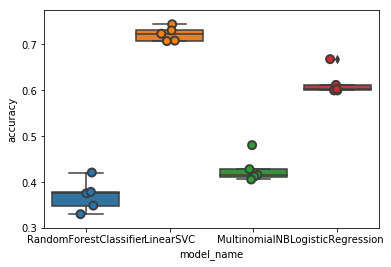

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()